## Overall variance

Words with the highest overall variance in the smoothed time series data. Captures words that dramatically increase, decrease, spike, fluctuate:

In [1]:
import math
import numpy as np

from hol.year_series import YearSeries

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

topns = YearSeries(range(1750, 1920), depth=1000, level1=1)

def small_multiples(result, n=50, cols=5):

    topn = list(result.items())[:n]
    
    # Get X-axis range.
    y1 = list(topns.years)[0]
    y2 = list(topns.years)[-1]
    
    # Calculate the row count and figure size.
    rows = math.ceil(n / 5)
    figsize = (cols*2, rows*2)
    
    # Make the figure + axes.
    fig, axarr = plt.subplots(rows, cols, figsize=figsize, sharey='row')
    fig.tight_layout(pad=0, h_pad=2, w_pad=0.1)
    
    for i, (token, score) in enumerate(topn):
        
        ax = axarr[math.floor(i/cols)][i%cols]
        
        # Query the smoothed rank series.
        series = topns.rank_series_smooth(token)
            
        ax.set_title(token)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
        ax.tick_params(labelsize=8)
        ax.set_xlim(y1, y2)
        ax.set_ylim(0, topns.depth)

        ax.plot(
            *zip(*series.items()),
            linestyle='none',
            marker=".",
            markersize=3,
        )

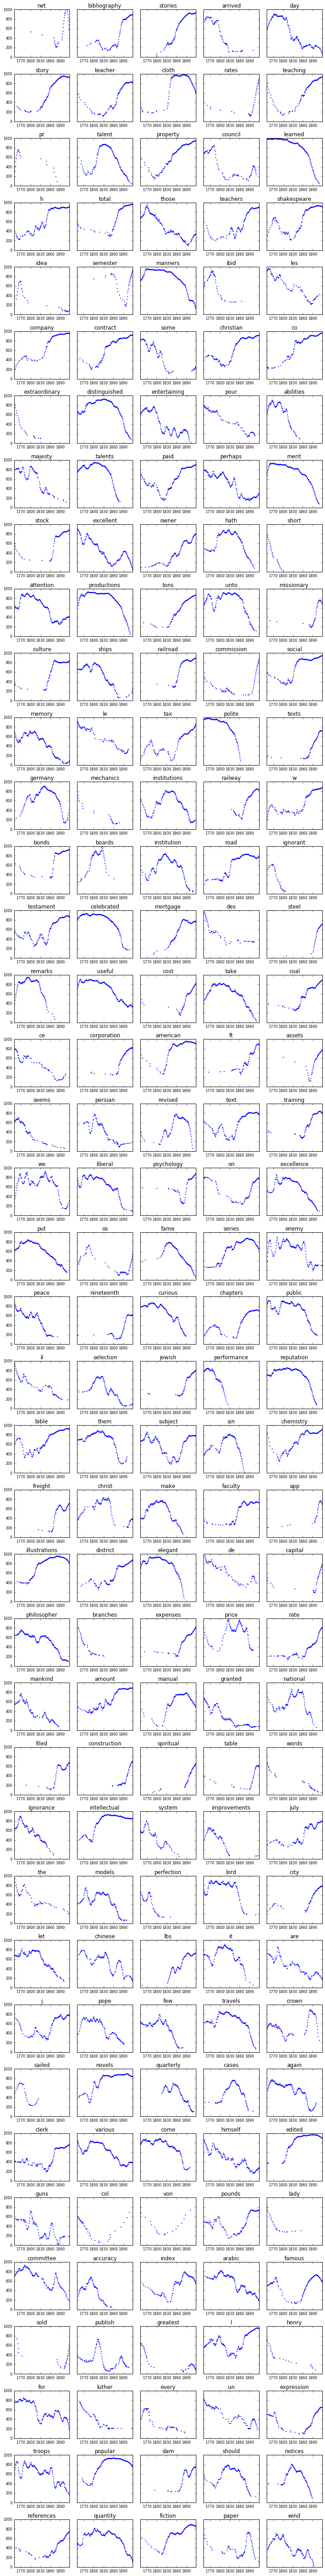

In [2]:
def print_series_query(_lambda, *args, **kwargs):
    result = topns.sort_smoothed_rank_series(_lambda)
    small_multiples(result, *args, **kwargs)

def score(s):
    return np.var(list(s.values()))

print_series_query(score, n=200)

## Trending up

Words that show the largest overall increase in rank over time:

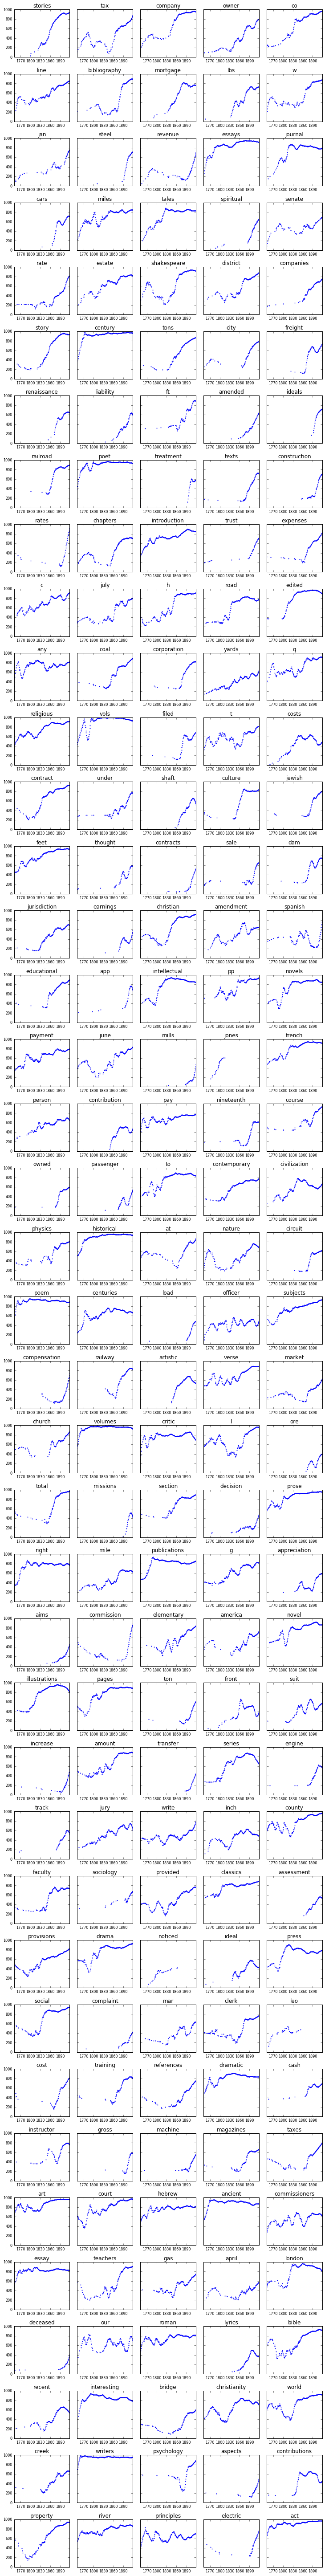

In [3]:
def score(s):
    y = list(s.values())
    return y[-1] - y[0]

print_series_query(score, n=200)

## Trending down

Words that show the largest overall decrease in rank over time:

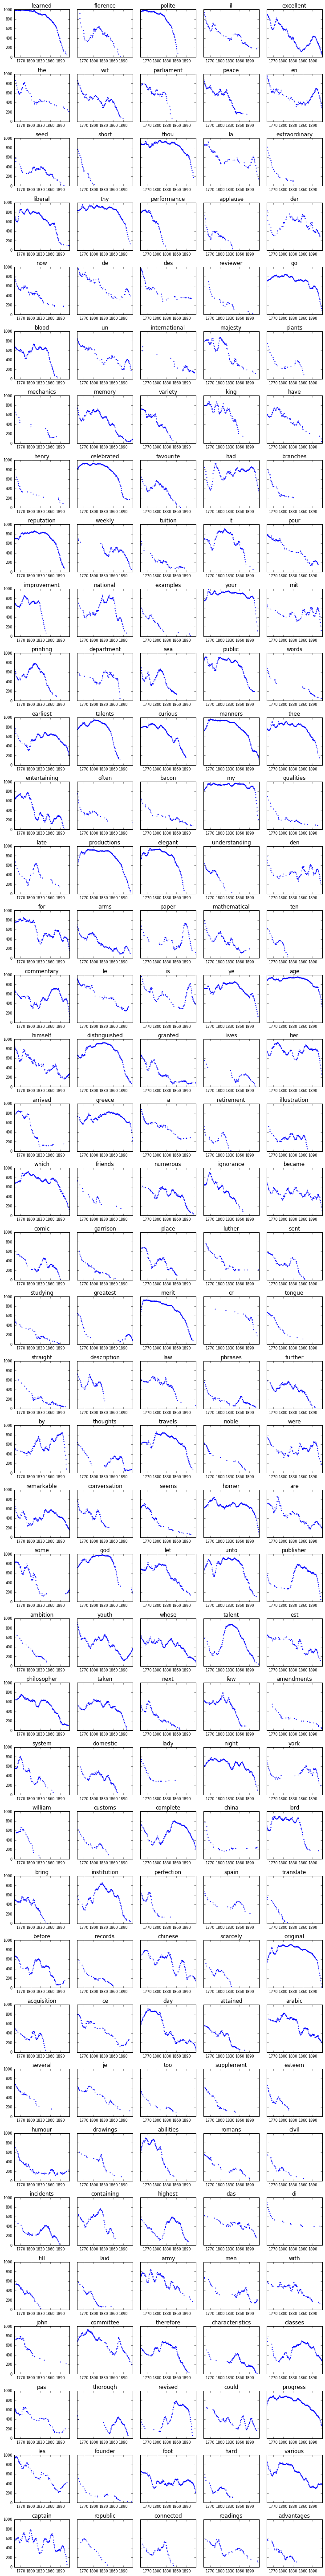

In [4]:
def score(s):
    y = list(s.values())
    return y[0] - y[-1]

print_series_query(score, n=200)

## Constant

Words that stay in the same place in the rankings over time:

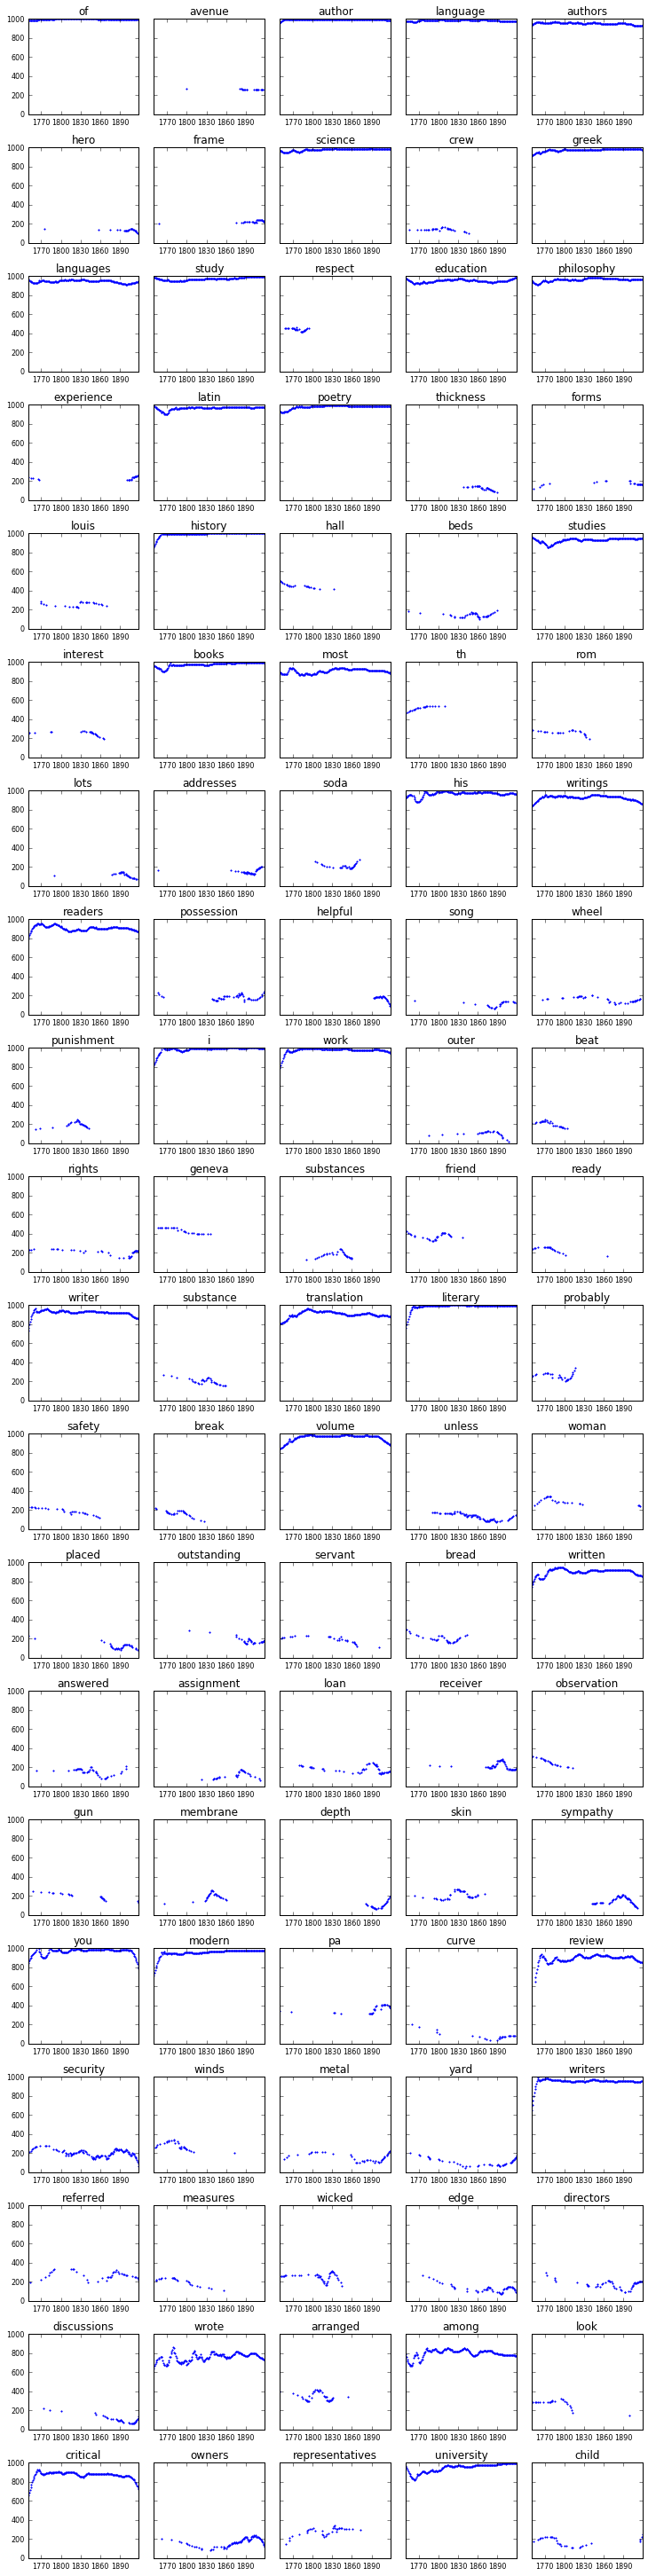

In [5]:
def score(s):
    return -np.var(list(s.values()))

print_series_query(score, n=100)

But, this doens't work as well because we're picking up on words that have low variance but that only show up for a very short amount of time, like "plate." What we want, really, is a way to capture the _trend_ of a word over a period of time, instead of just doing summary stats on the raw set of rank positions for a word - something that can pick out the difference between "literary" (constant at the top of the list from 1780-1920) and, say, "payment," which is relatively stable on the list after 1840, but totally missing before that.

## Time series -> density functions

To get at this, we can convert the rank time series into probability density functions (PDFs):

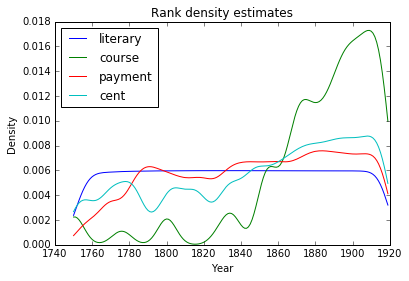

In [6]:
def plot_pdfs(tokens, legend=True):
    for t in tokens:
        
        samples = topns.pdf(t)
        
        plt.title('Rank density estimates')
        plt.xlabel('Year')
        plt.ylabel('Density')
        plt.plot(*zip(*samples.items()), label=t)
        
        if legend:
            plt.legend(loc='upper left')
        
    plt.show()
    
plot_pdfs([
    'literary',
    'course',
    'payment',
    'cent',
])

And, from this, it's easy to pick out "literary" as the most constant word just by ranking the words in terms of the lowest maximum value of their PDFs - that is, words that are spread evenly across the X axis and aren't able to concentrate a significant amount of mass under any given point.

### Constant PDFs

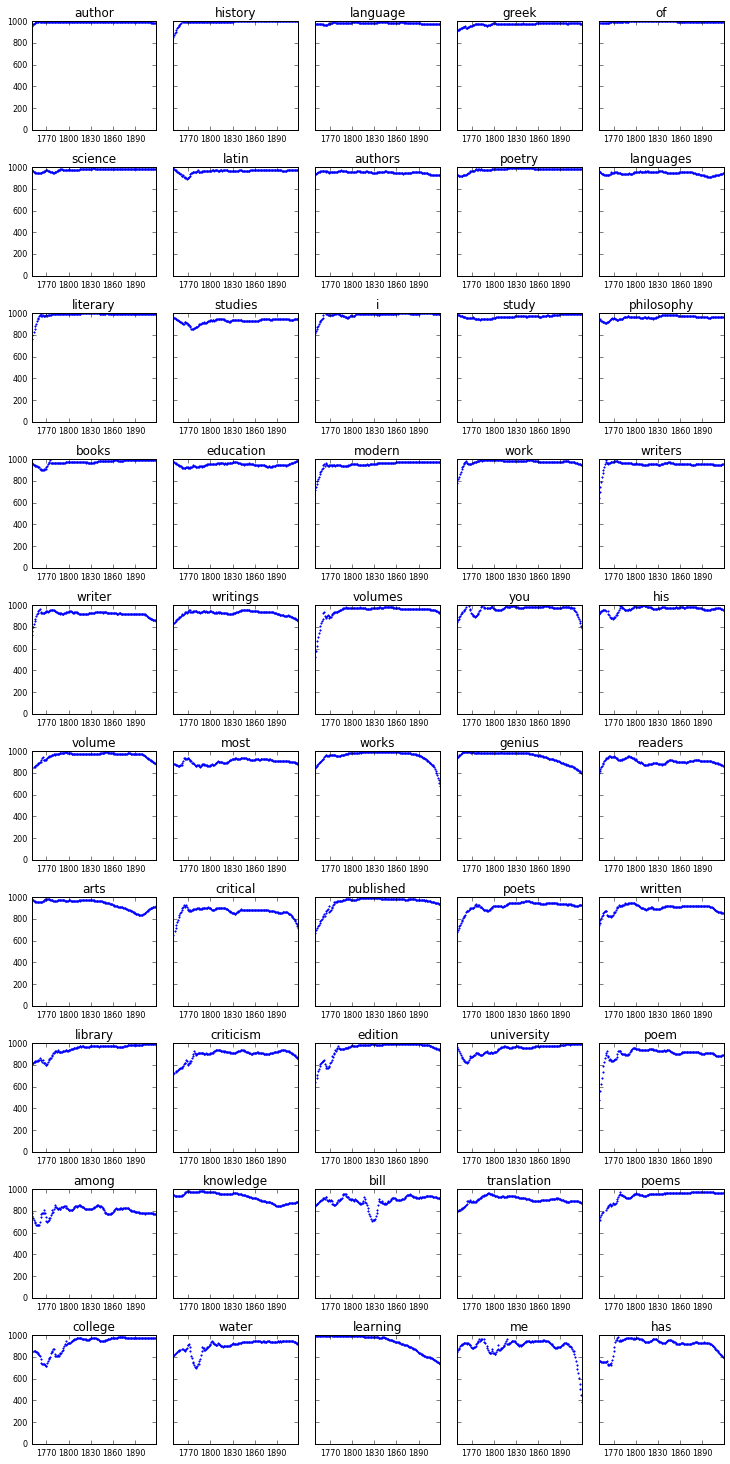

In [7]:
def print_pdf_query(_lambda, min_count=50, *args, **kwargs):
    result = topns.sort_pdfs(_lambda, min_count)
    small_multiples(result, *args, **kwargs,)
            
def score(s):
    return -max(list(s.values()))

print_pdf_query(score)

### "Peakiest" PDFs

Or, conversely, words that are the most concentrated over a particular temporal region.

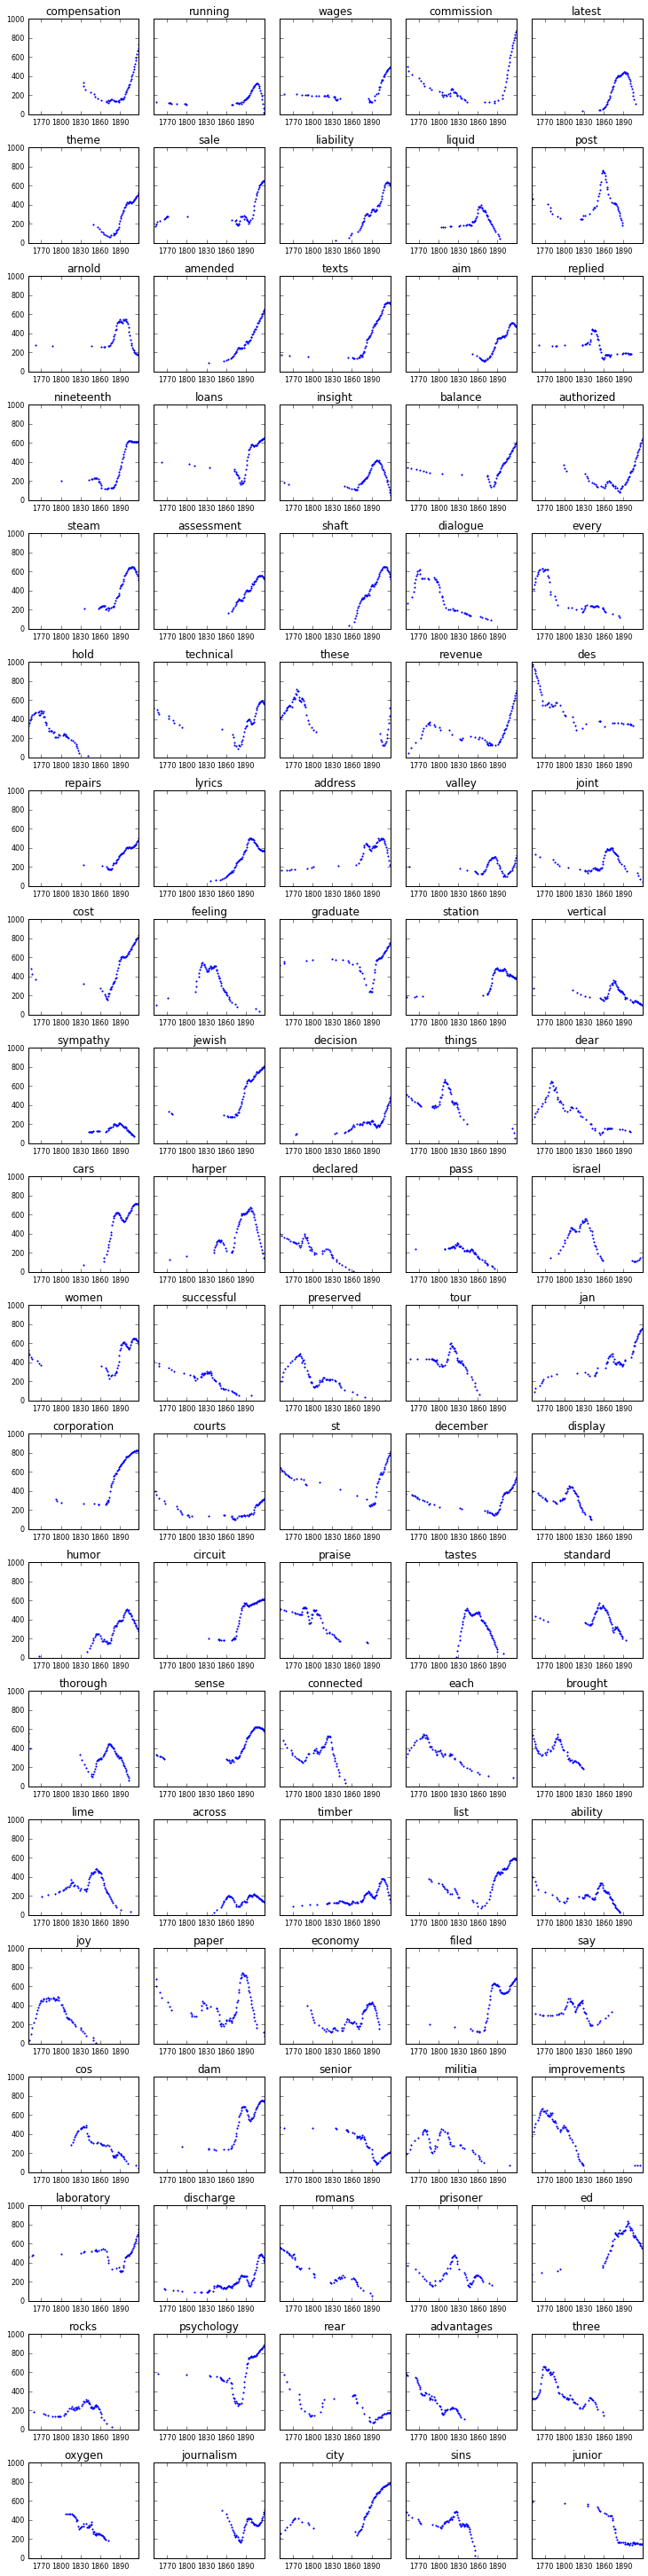

In [8]:
def score(s):
    return max(list(s.values()))

print_pdf_query(score, n=100)

### More like this

Another nice characteristic of the density functions is that we get access to a whole range of different ways of comaring the similarity between two words. Eg - given a token, what tokens have the most similar rank trends?

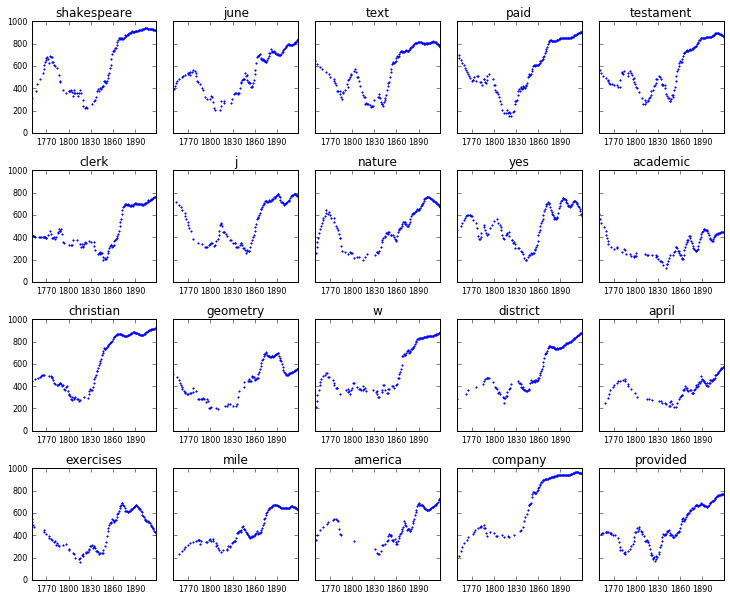

In [9]:
def print_pdfs_similar_to(token, min_count=30, *args, **kwargs):
    result = topns.pdfs_similar_to(token, min_count)
    small_multiples(result, *args, **kwargs)

print_pdfs_similar_to('shakespeare', n=20)

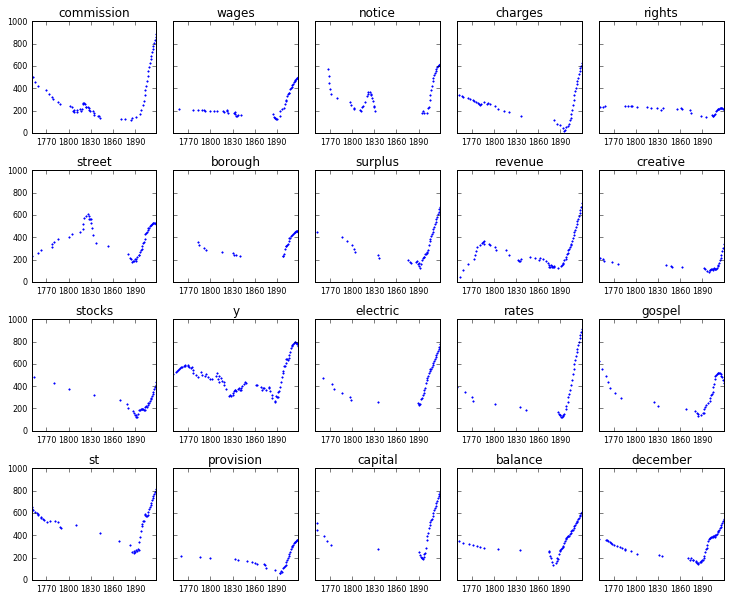

In [10]:
print_pdfs_similar_to('commission', n=20)

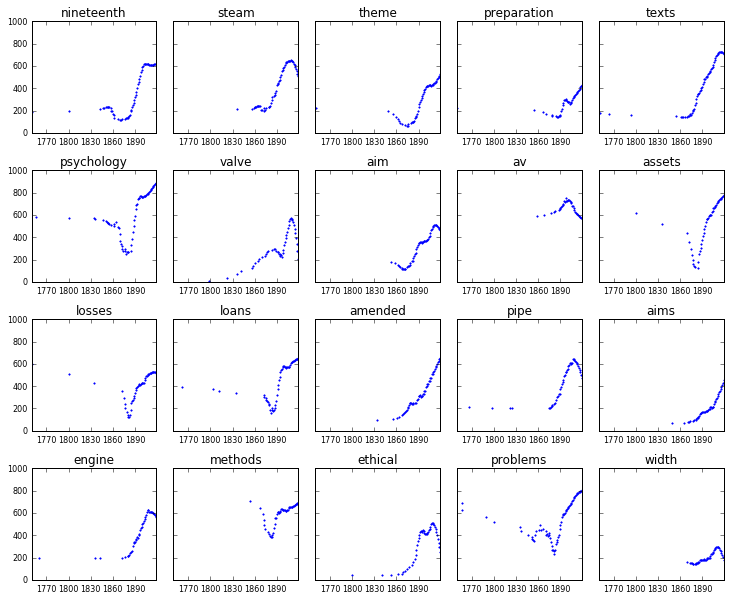

In [11]:
print_pdfs_similar_to('nineteenth', n=20)

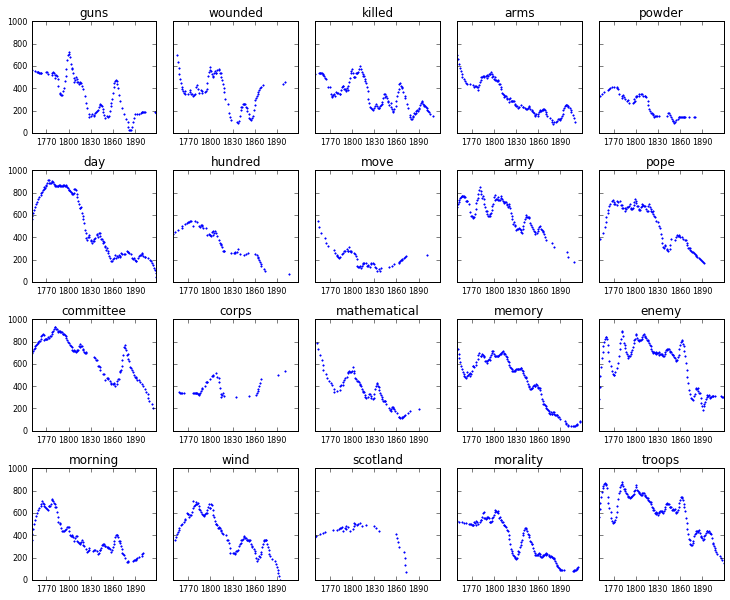

In [12]:
print_pdfs_similar_to('guns', n=20)

### MDW "churn" over time

Slide a window across the year range, compute the average pairwise Jaccard distance.

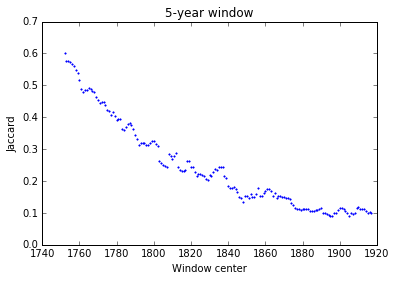

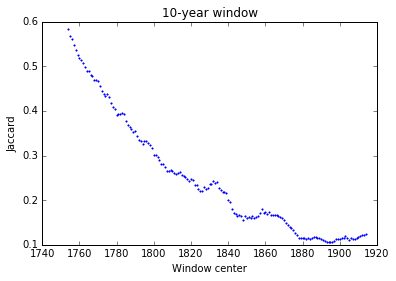

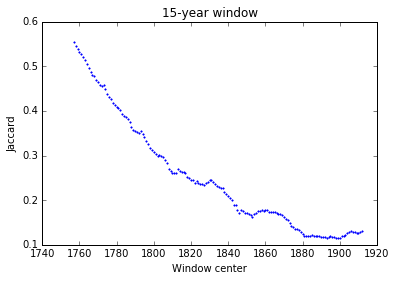

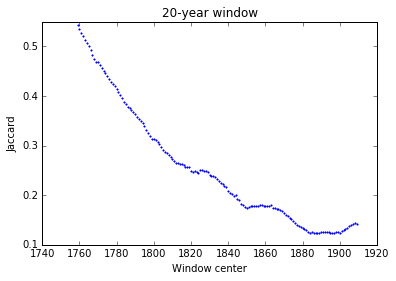

In [13]:
import math

from distance import sorensen
from itertools import combinations

from hol.utils import window

def plot_mdw_churn(width):

    churn = {}
    for w in window(topns.years, width):

        ds = []
        for y1, y2 in combinations(w, 2):
            tn1 = list(topns.topns[y1].keys())
            tn2 = list(topns.topns[y2].keys())
            ds.append(sorensen(tn1, tn2))

        center = math.floor((w[0] + w[-1])/2)

        churn[center] = sum(ds) / len(ds)
        
    plt.title('{0}-year window'.format(width))
    plt.xlabel('Window center')
    plt.ylabel('Jaccard')
    
    plt.plot(
        *zip(*churn.items()),
        linestyle='none',
        marker=".",
        markersize=3,
    )
    
    plt.show()
    
plot_mdw_churn(5)
plot_mdw_churn(10)
plot_mdw_churn(15)
plot_mdw_churn(20)

### 20-year bins, raw log-likelihood

In [14]:
from tabulate import tabulate
from collections import OrderedDict

from hol import cached

headers = [
    '1760-1780',
    '1780-1800',
    '1800-1820',
    '1820-1840',
    '1840-1860',
    '1860-1880',
    '1880-1900',
    '1900-1920',
]

buckets = [
    cached.mdw(year1=1760, year2=1780, level1=5),
    cached.mdw(year1=1780, year2=1800, level1=5),
    cached.mdw(year1=1800, year2=1820, level1=5),
    cached.mdw(year1=1820, year2=1840, level1=5),
    cached.mdw(year1=1840, year2=1860, level1=5),
    cached.mdw(year1=1860, year2=1880, level1=5),
    cached.mdw(year1=1880, year2=1900, level1=5),
    cached.mdw(year1=1900, year2=1920, level1=5),
]

table = []
for i in range(50):
    table.append([list(b.keys())[i] for b in buckets])
    
print(tabulate(table, headers=headers))

1780-1800    1800-1820    1820-1840     1840-1860     1860-1880    1880-1900    1900-1920
-----------  -----------  ------------  ------------  -----------  -----------  -----------
lectures     literary     literary      literary      english      english      english
history      history      language      history       history      history      history
english      of           poetry        language      literary     literary     professor
hours        language     i             poetry        professor    professor    literary
latin        german       history       english       language     poetry       poetry
german       poetry       of            i             poetry       language     language
professor    i            works         german        latin        books        study
course       science      german        professor     greek        study        books
greek        works        classical     works         german       german       greek
seniors      genius       wri

### 20-year bins, KDE max

1760-1780     1780-1800     1800-1820    1820-1840     1840-1860       1860-1880     1880-1900     1900-1920
------------  ------------  -----------  ------------  --------------  ------------  ------------  ------------
mankind       mankind       publish      era           era             revised       owner         owner
ignorance     ignorance     selection    selection     fame            era           teaching      teaching
indeed        there         sea          publish       highest         temperature   teachers      teachers
granted       materials     printing     fame          scenes          highest       chapters      chapters
morning       granted       there        picture       beauty          cloth         crown         story
report        guns          selected     sides         revised         geometry      revised       ethics
two           report        sides        scenes        brilliant       papers        story         theory
materials     remarks       nativ

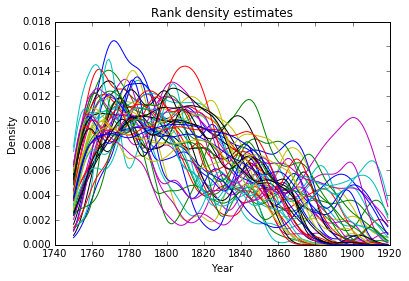

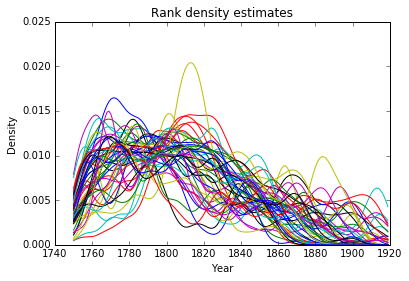

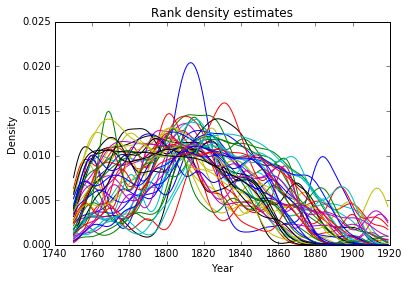

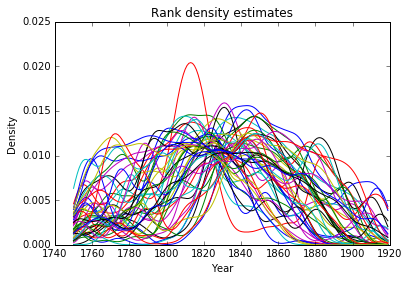

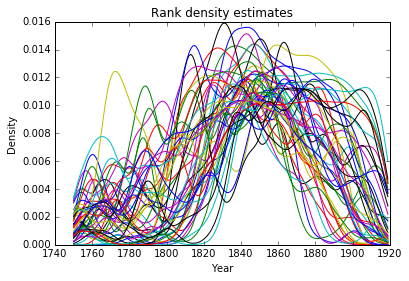

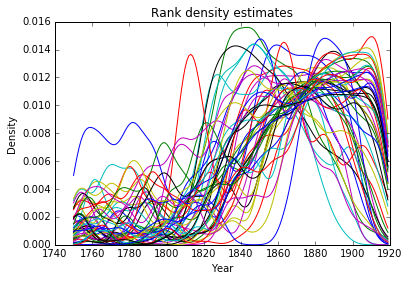

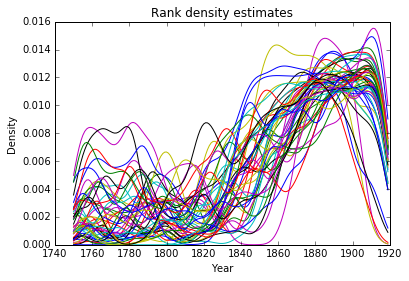

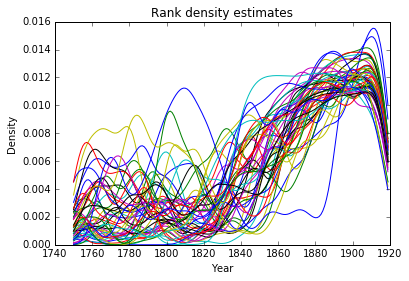

In [16]:
from functools import partial

def score(years, s):
    return max([s[y] for y in years])

headers = [
    '1760-1780',
    '1780-1800',
    '1800-1820',
    '1820-1840',
    '1840-1860',
    '1860-1880',
    '1880-1900',
    '1900-1920',
]

buckets = [topns.sort_pdfs(partial(score, years), min_count=100, bandwidth=10) for years in [
    range(1760, 1780),
    range(1780, 1800),
    range(1800, 1820),
    range(1820, 1840),
    range(1840, 1860),
    range(1860, 1880),
    range(1880, 1900),
    range(1900, 1920),
]]

table = []
for i in range(50):
    table.append([list(b.keys())[i] for b in buckets])
    
print(tabulate(table, headers=headers))

for b in buckets:
    plot_pdfs(list(b.keys())[:50], legend=False)